In [1]:
import sys
sys.path.insert(0, '../src')
from thecov.covariance import GaussianCovariance
from thecov.geometry import SurveyGeometry

from tqdm.notebook import tqdm

from nbodykit.source.catalog import CSVCatalog
from nbodykit.lab import cosmology, transform

import numpy as np

import matplotlib
from matplotlib import pyplot as plot
from matplotlib.colors import LinearSegmentedColormap

import itertools as itt

color_a = '#333'
color_b = '#e13'
color_c = '#1e3'

cmap = LinearSegmentedColormap.from_list("cmap_name", ['#04f', '#fff', '#f30'])

import scipy.special

def fgrowth(z, Om0):
    return(1. + 6*(Om0-1)*scipy.special.hyp2f1(4/3., 2, 17/6., (1-1/Om0)/(1+z)**3)
                  /( 11*Om0*(1+z)**3*scipy.special.hyp2f1(1/3., 1, 11/6., (1-1/Om0)/(1+z)**3) ))

## Calculating cartesian FFTs

In [2]:
cosmo = cosmology.Cosmology(h=0.7).match(Omega0_m=0.31)

# Let's use a 10x random catalog to make things faster for now

# From: https://data.sdss.org/sas/dr12/boss/lss/dr12_multidark_patchy_mocks/Patchy-Mocks-Randoms-DR12NGC-COMPSAM_V6C_x10.tar.gz
# Columns described in: http://skiesanduniverses.org/Products/MockCatalogues/SDSS/BOSSLRGDR12MDP/
randoms = CSVCatalog('data/Patchy-Mocks-Randoms-DR12NGC-COMPSAM_V6C_x10.dat',
                     names=['RA', 'DEC', 'Z', 'NZ', 'BIAS', 'VETO FLAG', 'Weight'],
                     delim_whitespace=True)

randoms = randoms[randoms['VETO FLAG'] > 0]
randoms = randoms[(randoms['Z'] > 0.5) * (randoms['Z'] < 0.75)]

randoms['WEIGHT_FKP'] = 1./(1. + 1e4*randoms['NZ'])

randoms['Position'] = transform.SkyToCartesian(
    randoms['RA'], randoms['DEC'], randoms['Z'], degrees=True, cosmo=cosmo)

# gcov.compute_cartesian_ffts(tqdm=tqdm)

In [2]:
geometry = SurveyGeometry(random_catalog=None, Nmesh=48, BoxSize=3750, alpha=1/10, tqdm=tqdm)
# geometry.set_kbins(0., 0.4, 0.005)

In [3]:
# geometry.compute_cartesian_ffts()

In [4]:
geometry.load_window_kernels('./data/winkernels.npz')
# geometry.load_cartesian_ffts('./data/cartesian_ffts.npz')

In [5]:
covariance = GaussianCovariance(geometry)
covariance.set_kbins(0, 0.4, 0.005)

In [6]:
covariance.compute_covariance()

array([[6.06149694e+06, 7.17759702e+05, 3.90095206e+04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.57068064e+05, 1.06437349e+06, 1.66586299e+05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.53493703e+04, 2.12122017e+05, 3.81769843e+05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.96092443e+03, 1.18317678e+03, 1.44307120e+02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.18176281e+03, 3.02437086e+03, 1.16300017e+03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.35119200e+02, 1.15212325e+03, 2.90718912e+03]])

In [7]:
from thecov import utils

/home/oalves/desi/analytical_covariance/thecov/example/../src/thecov/base.py:19: RuntimeWarning: invalid value encountered in sqrt
  v = np.sqrt(np.diag(cov))


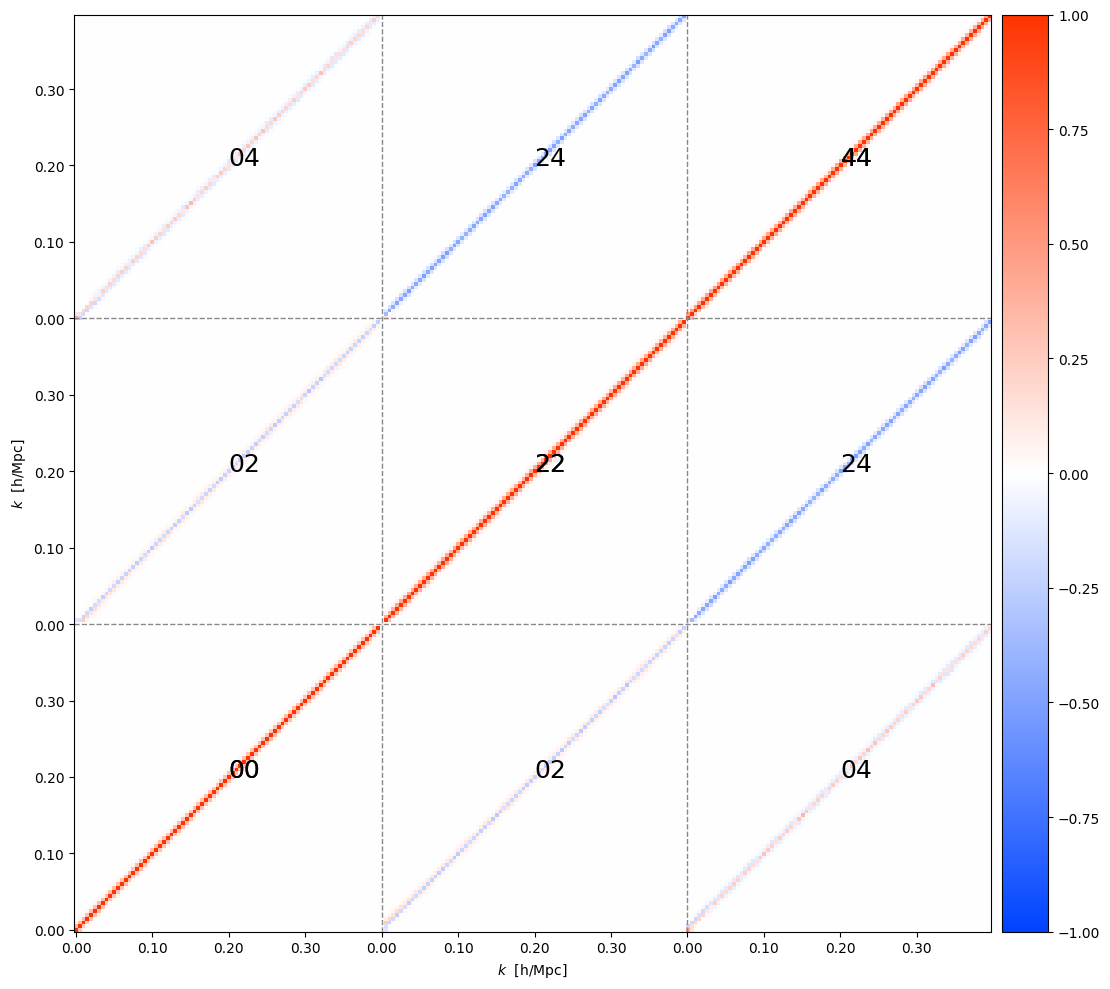

In [8]:
utils.plot_cov(covariance);

## Calculating window kernels

In [4]:
# cov.load_cartesian_ffts('data/cartesian_ffts.npz')
# gcov.set_kbins(0., 0.25, 0.005)
# gcov.compute_window_kernels(kmodes_sampled=250, icut=15, tqdm=tqdm)

Sorting k-modes in shells:   0%|          | 0/50 [00:00<?, ?it/s]

Computing window kernels:   0%|          | 0/50 [00:00<?, ?it/s]

In [15]:
gcov = thepowercov.GaussianSurveyWindowCovariance()
gcov.load_cartesian_ffts('data/cartesian_ffts.npz')
gcov.load_window_kernels('data/winkernels.npz')

## Gaussian covariance

In [17]:
# cov = ThePowerCov.GaussianSurveyWindowCovariance()
# cov.load_window_kernels('data/winkernels.npz')

pk_data = np.array([np.loadtxt(f'data/pre_recon_patchy_NGC_z3/ps1D_patchyDR12_ngc_combined_bianchi_z3_{i}_COMPnbar_TIC_340_650_360_120.dat',
                               skiprows=30, unpack=True, max_rows=50) for i in range(1,2049)])

k, _, P0, P2, P4, _, _ = np.average(pk_data, axis=0)

moving_average = lambda x,w: np.convolve(x, np.ones(w)/w, 'valid')

gcov.load_multipole(k, P0, 0)
gcov.load_multipole(k, P2, 2)
gcov.load_multipole(moving_average(k, 7), moving_average(P4, 7), 4)
# gcov.load_multipole(k, P2, 2)
# gcov.load_multipole(k, P4, 4)

gcov.set_kbins(0., 0.25, 0.005)

gcov.compute_covariance()

In [18]:
mockcov = PowerMultipoleCovariance.loadtxt('/home/oalves/desi/analytical_covariance/drive/Patchy_CovarianceMatrix.dat')

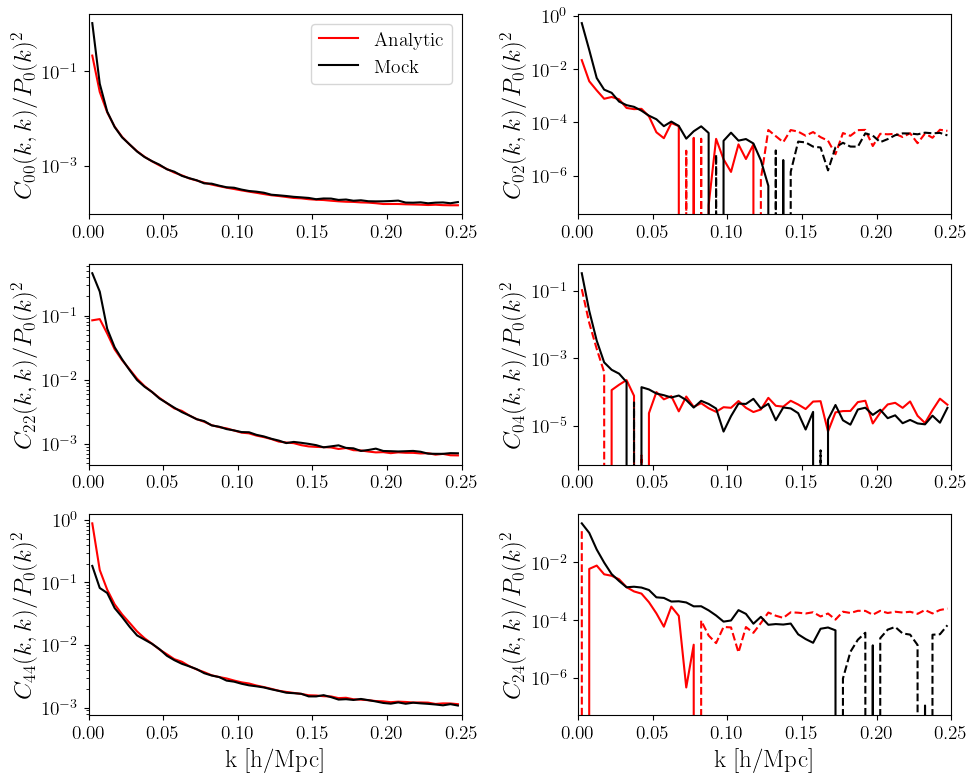

In [21]:
k = gcov.k

p2 = gcov.get_multipole_interpolator(0)(k)**2

fig, axes = plot.subplots(3, 2, figsize=(10,8), sharex=False)
for (l1, l2), ax in zip([(0,0), (2,2), (4,4), (0,2), (0,4), (2,4)], axes.T.flatten()):

    a = np.diag(gcov.get_multipole_covariance(l1,l2).cov)/p2
    b = np.diag(mockcov.get_multipole_covariance(l1,l2).cov)/p2
    
    ax.semilogy(k,  a, label='Analytic', c='r')
    ax.semilogy(k, -a, c='r', ls='dashed')

    ax.semilogy(k,  b, label='Mock', c='k')
    ax.semilogy(k, -b, c='k', ls='dashed')

    ax.set_ylabel(r"$C_{l1l2}(k,k)/P_0(k)^2$".replace('l1', str(l1)).replace('l2', str(l2)))
    ax.set_xlim(0, 0.25)
    
axes[2,0].set_xlabel('k [h/Mpc]')
axes[2,1].set_xlabel('k [h/Mpc]')
axes[0,0].legend()
fig.tight_layout()
# fig.subplots_adjust(hspace=0.05)

## Trispectrum
### Calculating trispectrum

In [ ]:
Om = 0.307115
z = 0.58 #mean redshift of the high-Z chunk
b1 = 1.94853182918671; #Linear bias
be = fgrowth(z, Om)/b1; #beta = f/b1, zero for real space
g2 = -2/7*(b1 - 1)
g3 = 11/63*(b1 - 1)
b2 = 0.412 - 2.143*b1 + 0.929*b1**2 + 0.008*b1**3 + 4/3*g2 
g2x = -2/7*b2
g21 = -22/147*(b1 - 1)
b3 = -1.028 + 7.646*b1 - 6.227*b1**2 + 0.912*b1**3 + 4*g2x - 4/3*g3 - 8/3*g21 - 32/21*g2

In [9]:
# tcov = ThePowerCov.TrispectrumSurveyWindowCovariance(gcov)

# tcov.set_bias_parameters(b1, be, g2, b2, g3, g2x, g21, b3)

# k_lin  = np.loadtxt('/home/oalves/desi/analytical_covariance/drive/k_Patchy.dat')
# Plin = np.loadtxt('/home/oalves/desi/analytical_covariance/drive/P0_fit_Patchy.dat')

# tcov.load_Plin(k_lin, Plin)

# tcov.compute_covariance(tqdm=tqdm)
# tcov.save('data/trispectrum_cov.npz')

Computing trispectrum contribution:   0%|          | 0/50 [00:00<?, ?it/s]

In [13]:
tcov = thepowercov.TrispectrumSurveyWindowCovariance.load('data/trispectrum_cov.npz')

## SSC

In [2]:
cosmo = cosmology.Cosmology(h=0.7).match(Omega0_m=0.31)

# Let's use a 10x random catalog to make things faster for now

# From: https://data.sdss.org/sas/dr12/boss/lss/dr12_multidark_patchy_mocks/Patchy-Mocks-Randoms-DR12NGC-COMPSAM_V6C_x10.tar.gz
# Columns described in: http://skiesanduniverses.org/Products/MockCatalogues/SDSS/BOSSLRGDR12MDP/
randoms = CSVCatalog('data/Patchy-Mocks-Randoms-DR12NGC-COMPSAM_V6C_x10.dat',
                     names=['RA', 'DEC', 'Z', 'NZ', 'BIAS', 'VETO FLAG', 'Weight'],
                     delim_whitespace=True)

randoms = randoms[randoms['VETO FLAG'] > 0]
randoms = randoms[(randoms['Z'] > 0.5) * (randoms['Z'] < 0.75)]

randoms['WEIGHT_FKP'] = 1./(1. + 1e4*randoms['NZ'])

randoms['Position'] = transform.SkyToCartesian(
    randoms['RA'], randoms['DEC'], randoms['Z'], degrees=True, cosmo=cosmo)

In [3]:
survey_window = SurveyWindow(randoms, Nmesh=300, BoxSize=7200., alpha=1/10, tqdm=tqdm)

In [4]:
gcov = thepowercov.GaussianSurveyWindowCovariance()
gcov.set_kbins(0., 0.25, 0.005)

scov = thepowercov.SuperSampleCovariance(survey_window, gcov)

scov.set_bias_parameters(b1, be, g2, b2, g3, g2x, g21, b3)

k_lin  = np.loadtxt('/home/oalves/desi/analytical_covariance/drive/k_Patchy.dat')
Plin = np.loadtxt('/home/oalves/desi/analytical_covariance/drive/P0_fit_Patchy.dat')

scov.load_Plin(k_lin, Plin)

In [9]:
scov.compute_covariance()

In [19]:
def plot_cov(cova, covb, k):

    fig, axes = plot.subplots(1, 1, figsize=(12,10), sharey=True)
    
    kBinsMock = len(k)

    min_k, max_k= min(k), max(k)
    i2k_fac = ((max_k - min_k)/kBinsMock)

    axes.xaxis.set_major_formatter(plot.FuncFormatter(lambda v,i: f'{(v%kBinsMock)*i2k_fac + min_k:.1f}'))
    axes.yaxis.set_major_formatter(plot.FuncFormatter(lambda v,i: f'{(v%kBinsMock)*i2k_fac + min_k:.1f}'))

    axes.set_xticks(np.arange(3*kBinsMock, step=kBinsMock/5))
    axes.set_yticks(np.arange(3*kBinsMock, step=kBinsMock/5))

    for i in range(3):
        axes.axvline((i+1)*kBinsMock,  color='#888', ls='dashed', lw=1)
        axes.axhline((i+1)*kBinsMock,  color='#888', ls='dashed', lw=1)
    #     axes.axvline(i*kBinsMock + 40, color='#fcc', ls='dashed', lw=1)
    #     axes.axhline(i*kBinsMock + 40, color='#fcc', ls='dashed', lw=1)

    axes.set_xlabel(r"$k$  [h/Mpc]")
    axes.set_ylabel(r"$k$  [h/Mpc]")

    ki_04 = np.argmin((k - 0.4)**2)

    # for i,j in itt.product(range(3), repeat=2):
    #     frac = ((0.4-min_k)/(max_k-min_k))/3
    #     axes.axhline(y=i*kBinsMock + ki_04, xmin=j/3, xmax=j/3 + frac, color='#888', ls='dashed', lw=1)
    #     axes.axvline(x=i*kBinsMock + ki_04, ymin=j/3, ymax=j/3 + frac, color='#888', ls='dashed', lw=1)

    for i,j in itt.combinations_with_replacement(range(0,3), 2):
        axes.text((i+1/2)*kBinsMock - 5, (j+1/2)*kBinsMock - 5, f'{2*i}{2*j}', fontsize='18')
        axes.text((j+1/2)*kBinsMock - 5, (i+1/2)*kBinsMock - 5, f'{2*i}{2*j}', fontsize='18')

    # axes.text(10, 3*kBinsMock+20, r'$P_\ell(k)$ correlation matrix. Small dashed boxes delimit $k < 0.4$ h/Mpc.')

    def triangle_cov(upper, lower, diagonal='upper'):
        assert diagonal in ['upper', 'lower']
        cov = np.triu(upper) + np.tril(lower)
        cov -= np.diag(np.diag(upper if diagonal == 'lower' else lower))
        return cov

    def cov2corr(cov):
        v = np.sqrt(np.diag(cov))
        outer_v = np.outer(v, v)
        outer_v[outer_v == 0] = np.inf
        correlation = cov / outer_v
        correlation[cov == 0] = 0
        return correlation
    
    cov = triangle_cov(covb.cov, cova.cov)
    
    fig.colorbar(axes.imshow(cov2corr(cov), origin='lower', vmin=-1, vmax=1, cmap=cmap), pad=0.01)
    fig.tight_layout()
    # fig.savefig('/home/oalves/fig.png')

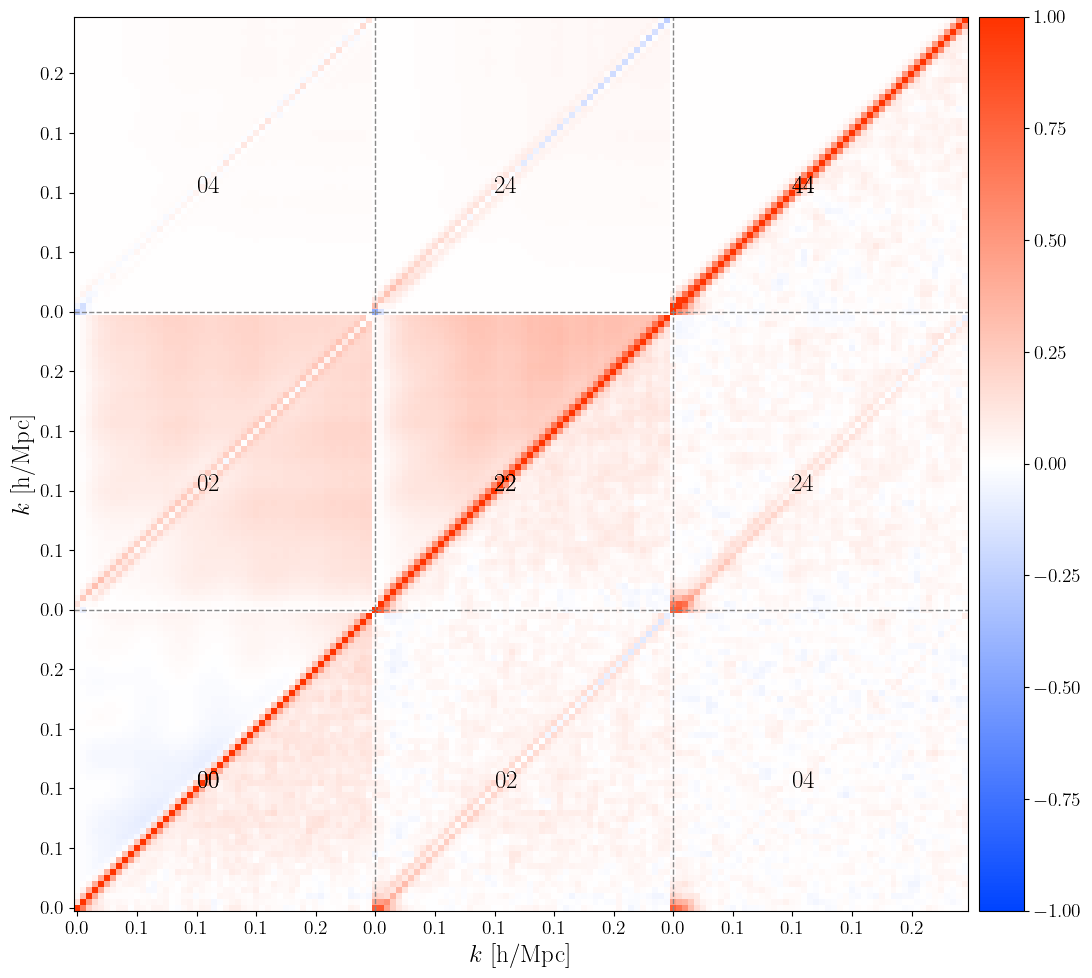

In [34]:
plot_cov(gcov+tcov+scov, mockcov, k=gcov.k)

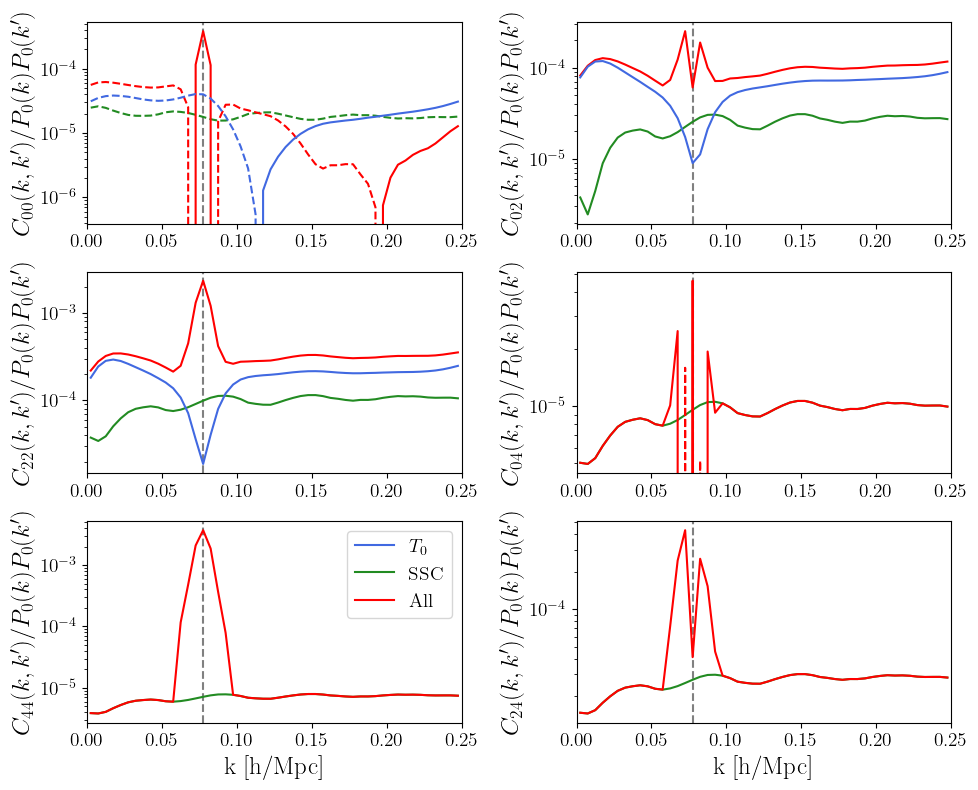

In [45]:
k = gcov.k

i = 15

p2 = gcov.get_multipole_interpolator(0)(k)*gcov.get_multipole_interpolator(0)(k[i])

fig, axes = plot.subplots(3, 2, figsize=(10,8), sharex=False)
for (l1, l2), ax in zip([(0,0), (2,2), (4,4), (0,2), (0,4), (2,4)], axes.T.flatten()):

    g = gcov.get_multipole_covariance(l1,l2).cov[i,:]/p2
    t = tcov.get_multipole_covariance(l1,l2).cov[i,:]/p2
    s = scov.get_multipole_covariance(l1,l2).cov[i,:]/p2
    
    gt  = g+t
    gs  = g+s
    gts = g+t+s
    
    m = mockcov.get_multipole_covariance(l1,l2).cov[i,:]/p2

    ax.axvline(k[i], ls='dashed', c='gray')

    ax.semilogy(k,  t, label='$T_0$', c='royalblue', zorder=5)
    ax.semilogy(k, -t, c='royalblue', ls='dashed', zorder=5)

    ax.semilogy(k,  s, label='SSC', c='forestgreen')
    ax.semilogy(k, -s, c='forestgreen', ls='dashed')
    
    ax.semilogy(k,  gts, label='All', c='r')
    ax.semilogy(k, -gts, c='r', ls='dashed')
    
#     ax.semilogy(k,  m, label='Mock', c='k')
#     ax.semilogy(k, -m, c='k', ls='dashed')

    ax.set_ylabel(r"$C_{l1l2}(k,k')/P_0(k)P_0(k')$".replace('l1', str(l1)).replace('l2', str(l2)))
    ax.set_xlim(0, 0.25)
    
axes[2,0].set_xlabel('k [h/Mpc]')
axes[2,1].set_xlabel('k [h/Mpc]')
axes[2,0].legend()
fig.tight_layout()
# fig.subplots_adjust(hspace=0.05)